In [1]:
# import librosa
# import IPython.display
# import matplotlib as mpl
# import matplotlib.font_manager as fm

In [2]:
# data.zip 파일 업로드

In [3]:
########################################################################
# import default python-library
########################################################################
import pickle
import os
import sys
import glob
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy as np
import librosa
import librosa.core
import librosa.display
import librosa.feature
import yaml
import logging
# from import
from tqdm import tqdm
from sklearn import metrics
from keras.models import Model
from keras.layers import Input, Dense
########################################################################

In [4]:
########################################################################
# setup STD I/O
########################################################################
"""
Standard output is logged in "autoencoder.log".
"""
logging.basicConfig(level=logging.DEBUG, filename="autoencoder.log")
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
########################################################################

In [5]:
# 현재 스크립트 실행 경로 출력
print(os.getcwd())
# c:\workspace\autoencoder\03_ELECTRIC-ENGINE

c:\workspace\autoencoder\03_ELECTRIC-ENGINE


In [6]:
# 스크립트 실행 경로 변경
# c:\workspace\autoencoder\03_ELECTRIC-ENGINE 으로 변경
os.chdir('c:/workspace/autoencoder/03_ELECTRIC-ENGINE')

In [7]:
# 현재 스크립트 실행 경로 출력
print(os.getcwd())

c:\workspace\autoencoder\03_ELECTRIC-ENGINE


In [8]:
# 하위에 dataset 폴더가 존재하지 않으면 생성
os.makedirs('./dataset', exist_ok=True)

In [9]:
# zip file(.wav files) 압축 해제
import zipfile


In [10]:
fantasy_zip = zipfile.ZipFile('./mimii_dg_bearing_wav_file.zip')
fantasy_zip.extractall('./dataset/')
fantasy_zip.close()

In [11]:
########################################################################

# wav file Input
def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))


def demux_wav(wav_name, channel=0):
    """
    demux .wav file.

    wav_name : str
        target .wav file
    channel : int
        target channel number

    return : numpy.array( float )
        demuxed mono data

    Enabled to read multiple sampling rates.

    Enabled even one channel.
    """
    try:
        multi_channel_data, sr = file_load(wav_name)
        if multi_channel_data.ndim <= 1:
            return sr, multi_channel_data

        return sr, np.array(multi_channel_data)[channel, :]

    except ValueError as msg:
        logger.warning(f'{msg}')


########################################################################

In [12]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge(SOURCE,
               TARGET,
               FIG_SIZE,
               n_mels=64,
               frames=5,
               n_fft=1024,
               hop_length=512,
               power=2.0):

    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # file = SOURCE
    # y, sr = librosa.load(file) # (default  sr=22050)
    # Return
      # y: np.ndarray [shape=(n,) or (…, n)] / audio time series. Multi-channel is supported.
      # sr: number > 0 [scalar / sampling rate of
    # S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # Returns
      # S: np.ndarray [shape=(…, n_mels, t)] / Mel spectrogram
    S_dB = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if TARGET == '':
      plt.figure(figsize=FIG_SIZE)
      librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
      plt.title('power_to_db')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=FIG_SIZE)
      plt.axis('off')
      librosa.display.specshow(S_dB, sr=sr)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [13]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
# https://ahnjg.tistory.com/83
# https://lucaseo.github.io/posts/2021-01-22-hands-on-preprocess-audio-data/
def make_iamge2(SOURCE, TARGET, FIG_SIZE):

    # 01 calculate the number of dimensions
    #dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # STFT -> spectrogram
    n_fft = 1024  # window in num. of samples
    hop_length = 512  # in num. of samples

    # perform stft
    stft = librosa.stft(y=y,
                        n_fft=n_fft,
                        hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft)  # np.abs(stft) ** 2

    # apply logarithm to cast amplitude to Decibels
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

      
    if TARGET == '':
      plt.figure(figsize=FIG_SIZE)
      librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
      plt.title('amplitude_to_db')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=FIG_SIZE)
      plt.axis('off')
      librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [27]:
s_apth="./dataset/mimii_dg_bearing_wav_file/normal/section_00_source_test_normal_0001_vel_18.wav"
s_apth1 = "./dataset/mimii_dg_bearing_wav_file/normal/section_00_source_test_normal_0001_vel_18.wav"

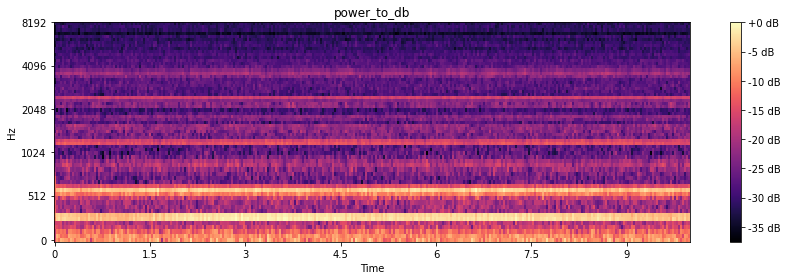

In [28]:
make_iamge(SOURCE=s_apth, TARGET='', FIG_SIZE=(12, 4))

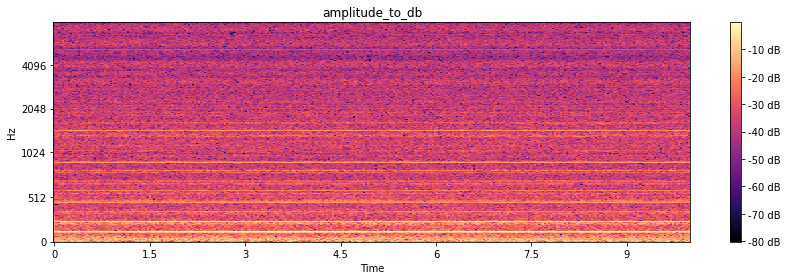

In [29]:
make_iamge2(SOURCE=s_apth, TARGET='', FIG_SIZE=(12, 4))

In [14]:
# https://wfdb.readthedocs.io/en/latest/
# The native Python waveform-database (WFDB) package
# A library of tools for reading, writing, and processing WFDB signals and annotations.
import wfdb

In [15]:
# wav파일별로 Spectrogram 변환 실행위한 경로 변수 설정
# in_path = './content/data/wav_split_final/'
# out_path = './content/data/out/'
in_path = './dataset/mimii_dg_bearing_wav_file/'
out_path = './dataset/mimii_dg_bearing_out/'
FIG_SIZE = (10, 10)
# label_path = ['abnormal','normal']
label_path = next(os.walk(in_path))[1]
len(label_path)

import os
# walk = os.walk("./content/data/wav_split_final/")
walk = os.walk("./dataset/mimii_dg_bearing_wav_files/")
print(walk)

# Spectrogram image 변환 결과물 저장 위해 폴더 및 파일 삭제
import shutil
# shutil.rmtree(r'./content/data/out')
try:
    if os.path.exists('./dataset/mimii_dg_bearing_out'):
        print("exist")
        shutil.rmtree(r'./dataset/mimii_dg_bearing_out')
        print("deleted")
except OSError:
    print ('Error: Creating directory. ' +  './dataset/mimii_dg_bearing_out')

<generator object _walk at 0x00000232ECD10120>


In [18]:
import os
# Spectrogram image 변환 결과물 저장폴더생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
# outfolder = './content/data/out'
outfolder = './dataset/mimii_dg_bearing_out'
createFolder(outfolder)
for i in label_path:
  createFolder(outfolder+'/'+i)

In [20]:
from tqdm import tqdm
# wav파일별로 Spectrogram 변환 실행
count = 0
print("wav folders:", label_path)
for i in label_path:
        file_list = os.listdir(in_path+i)
        count = count + 1
        print(count,"/",len(label_path),' \'',i,'\'')
        for j in tqdm(file_list, position=0, leave=True):
            SOURCE = in_path+i+"/"+j
            TARGET = out_path+i+"/"+j[:-3]+"jpg"
            make_iamge2(SOURCE, TARGET, FIG_SIZE)

wav folders: ['abnormal', 'normal']
1 / 2  ' abnormal '


100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


2 / 2  ' normal '


100%|██████████| 1100/1100 [02:44<00:00,  6.70it/s]


In [20]:
# wav파일별로 Spectrogram 변환 실행위한 경로 변수 설정
# in_path = './content/data/wav_split_final/'
# out_path = './content/data/out/'
in_path = './dataset/57cc_wav_files/'
out_path = './dataset/57cc_out/'
FIG_SIZE = (20, 20)
# label_path = ['abnormal','normal']
label_path = next(os.walk(in_path))[1]
len(label_path)

import os
# walk = os.walk("./content/data/wav_split_final/")
walk = os.walk("./dataset/36_57_wav_files/")
print(walk)

# Spectrogram image 변환 결과물 저장 위해 폴더 및 파일 삭제
import shutil
# shutil.rmtree(r'./content/data/out')
try:
    if os.path.exists('./dataset/57cc_out'):
        print("exist")
        shutil.rmtree(r'./dataset/57cc_out')
        print("deleted")
except OSError:
    print ('Error: Creating directory. ' +  './dataset/57cc_out')

<generator object _walk at 0x0000026A92DE86D0>


In [21]:
import os
# Spectrogram image 변환 결과물 저장폴더생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
# outfolder = './content/data/out'
outfolder = './dataset/57cc_out'
createFolder(outfolder)
for i in label_path:
  createFolder(outfolder+'/'+i)

In [22]:
from tqdm import tqdm
# wav파일별로 Spectrogram 변환 실행
count = 0
print("wav folders:", label_path)
for i in label_path:
        file_list = os.listdir(in_path+i)
        count = count + 1
        print(count,"/",len(label_path),' \'',i,'\'')
        for j in tqdm(file_list, position=0, leave=True):
            SOURCE = in_path+i+"/"+j
            TARGET = out_path+i+"/"+j[:-3]+"jpg"
            make_iamge2(SOURCE, TARGET, FIG_SIZE)

wav folders: ['abnormal', 'normal', 'normal_test']
1 / 3  ' abnormal '


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


2 / 3  ' normal '


100%|██████████| 41/41 [00:56<00:00,  1.38s/it]


3 / 3  ' normal_test '


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


In [23]:
# wav파일별로 Spectrogram 변환 실행위한 경로 변수 설정
# in_path = './content/data/wav_split_final/'
# out_path = './content/data/out/'
in_path = './dataset/36_57_wav_files/'
out_path = './dataset/36_57_out/'
FIG_SIZE = (20, 20)
# label_path = ['abnormal','normal']
label_path = next(os.walk(in_path))[1]
len(label_path)

import os
# walk = os.walk("./content/data/wav_split_final/")
walk = os.walk("./dataset/36_57_wav_files/")
print(walk)

# Spectrogram image 변환 결과물 저장 위해 폴더 및 파일 삭제
import shutil
# shutil.rmtree(r'./content/data/out')
try:
    if os.path.exists('./dataset/36_57_out'):
        print("exist")
        shutil.rmtree(r'./dataset/36_57_out')
        print("deleted")
except OSError:
    print ('Error: Creating directory. ' +  './dataset/36_57_out')

<generator object _walk at 0x0000026A92AEDC10>


In [24]:
import os
# Spectrogram image 변환 결과물 저장폴더생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
# outfolder = './content/data/out'
outfolder = './dataset/36_57_out'
createFolder(outfolder)
for i in label_path:
  createFolder(outfolder+'/'+i)

In [25]:
# from tqdm import tqdm
# # wav파일별로 Spectrogram 변환 실행
# count = 0
# print("wav folders:", label_path)
# for i in label_path:
#         file_list = os.listdir(in_path+i)
#         count = count + 1
#         print(count,"/",len(label_path),' \'',i,'\'')
#         for j in tqdm(file_list, position=0, leave=True):
#             SOURCE = in_path+i+"/"+j
#             TARGET = out_path+i+"/"+j[:-3]+"jpg"
#             make_iamge(SOURCE, TARGET)

In [26]:
from tqdm import tqdm
# wav파일별로 Spectrogram 변환 실행
count = 0
print("wav folders:", label_path)
for i in label_path:
        file_list = os.listdir(in_path+i)
        count = count + 1
        print(count,"/",len(label_path),' \'',i,'\'')
        for j in tqdm(file_list, position=0, leave=True):
            SOURCE = in_path+i+"/"+j
            TARGET = out_path+i+"/"+j[:-3]+"jpg"
            make_iamge2(SOURCE, TARGET, FIG_SIZE)

wav folders: ['abnormal', 'normal', 'normal_test']
1 / 3  ' abnormal '


100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


2 / 3  ' normal '


100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


3 / 3  ' normal_test '


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


In [ ]:
# import PIL
# import PIL.Image
# import tensorflow as tf
# import tensorflow_datasets as tfds

# 이미지 로드 및 전처리
# 참고: https://www.tensorflow.org/tutorials/load_data/images?hl=ko
#       Tensorflow공식 튜토리얼: 이미지 로드 및 전처리하기 
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

In [ ]:
# 데이터세트 형식으로 만들기
import pathlib

# data_dir = pathlib.Path('./content/data/out')
data_dir = pathlib.Path('./dataset/36cc_out')
print(type(data_dir))
print(data_dir)

In [ ]:
# image count
# image_count = len(list(data_dir.glob('*/*.jpg')))
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

In [ ]:
# image 1개 보기
# a_h = list(data_dir.glob('a_h/*'))
normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[11]))

In [ ]:
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pathlib
import librosa
import librosa.display
import concurrent.futures

In [ ]:
'''
2. Load training images  
'''
# resize and normalize data for training


def create_training_data(data_path, size=224):
    training_data = []
    # for category in CATEGORIES:  # "baseline" and "rattle"

    #     path = os.path.join(data_path, category)  # create path
    #     # get the classification  (0 or a 1). 0=baseline 1=rattle
    #     class_index = CATEGORIES.index(category)

    # iterate over each image
    for image in os.listdir(data_path):
        # check file extention
        if image.endswith(".jpg"):
            try:
                data_path = pathlib.Path(data_path)
                full_name = str(pathlib.Path.joinpath(data_path, image))
                data = cv2.imread(str(full_name), 0)
                # resize to make sure data consistency
                resized_data = cv2.resize(data, (size, size))
                # add this to our training_data
                training_data.append([resized_data])
            except Exception as err:
                print("an error has occured: ", err, str(full_name))

    # normalize data
    training_data = np.array(training_data)/255.
    # reshape
    training_data = np.array(training_data).reshape(-1, size, size)
    return training_data

In [ ]:
'''
3. Build autoencoder 
'''
# Define a convolutional Autoencoder


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # input layer
        self.latent_dim = latent_dim
        # 1st dense layer
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(224*224, activation='sigmoid'),
            layers.Reshape((224, 224))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
'''
4. Set threshold
'''


def model_threshold(autoencoder, x_train):
    encoded_imgs = autoencoder.encoder(x_train).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    loss = tf.keras.losses.mse(decoded_imgs, x_train)
    threshold = np.mean(loss) + np.std(loss)
    return threshold

In [ ]:
'''
5. Make an inference
'''


def spectrogram_loss(autoencoder, spectrogram, size=224):
    data = np.ndarray(shape=(1, size, size), dtype=np.float32)
    # individual sample
    # Load an image from a file
    data = cv2.imread(str(spectrogram), 0)
    # resize to make sure data consistency
    resized_data = cv2.resize(data, (size, size))
    # nomalize img
    normalized_data = resized_data.astype('float32') / 255.
    # test an image
    encoded = autoencoder.encoder(normalized_data.reshape(-1, size, size))
    decoded = autoencoder.decoder(encoded)
    loss = tf.keras.losses.mse(decoded, normalized_data)
    sample_loss = np.mean(loss) + np.std(loss)
    return sample_loss

In [ ]:
'''
2. Load training images
'''
data_path = "./dataset/36cc_out/normal"
x_train = create_training_data(data_path)

data_path = "./dataset/36cc_out/normal_test"
x_test = create_training_data(data_path)

In [ ]:
'''
3. Build autoencoder 
'''
autoencoder = Autoencoder(latent_dim=64 * 4)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(x_train, x_train,
						  epochs=10,
						  shuffle=True,
						  validation_data=(x_test, x_test))

In [ ]:
# a summary of architecture
autoencoder.encoder.summary()
autoencoder.decoder.summary()

In [ ]:
# plot history
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
# save and load a mode
autoencoder.save('./model/')
autoencoder = keras.models.load_model('./model/')

In [ ]:
# load autoencoder model
if autoencoder is None:
	autoencoder = Autoencoder(latent_dim=64 * 2)
	autoencoder = keras.models.load_model('./model/')

In [ ]:
'''
4. Set threshold
'''
threshold = model_threshold(autoencoder, x_train)
# loss = tf.keras.losses.mse(decoded_imgs, x_train)
# threshold = np.mean(loss) + np.std(loss)
print("Loss Threshold: ", threshold)

In [ ]:
# load autoencoder model
if autoencoder is None:
	autoencoder = keras.models.load_model('./model/')

In [ ]:
'''
5. Make an inference
'''
# get statistics for each spectrogram
# file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
file = './dataset/36cc_out/abnormal/2208211119H0010019698_TDM_2022-03-30_16-22-03__Microphone.jpg'
sample = plt.imread(file)
plt.imshow(sample)
sample = pathlib.Path(file)
sample_loss = spectrogram_loss(autoencoder, sample)

In [ ]:
if sample_loss > threshold:
	print(
		f'Loss is bigger than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')
else:
	print(
		f'Loss is smaller than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')

In [ ]:
'''
5. Make an inference
'''
# get statistics for each spectrogram
# file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
file = './dataset/36cc_out/abnormal/2208212119H0010019788_TDM_2022-03-30_15-55-34__Microphone.jpg'
sample = plt.imread(file)
plt.imshow(sample)
sample = pathlib.Path(file)
sample_loss = spectrogram_loss(autoencoder, sample)

In [ ]:
if sample_loss > threshold:
	print(
		f'Loss is bigger than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')
else:
	print(
		f'Loss is smaller than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')

In [ ]:
'''
K-fold validation
'''
k = 4
num_val_samples = len(X) // k

num_epochs = 100
all_scores = []

for i in range(k):
    print(f"Processing fold #{i}")
    val_data = X[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y[i * num_val_samples: (i + 1) * num_val_samples]
    # i = 0 ==> val_data = X[0:9], val_targets = y[0:9]        
    # i = 1 ==> val_data = X[9:18], val_targets = y[9:18]     
    # i = 2 ==> val_data = X[18:27], val_targets = y[18:27]     
    # i = 3 ==> val_data = X[27:36], val_targets = y[27:36]
    partial_train_data = np.concatenate(
        [X[:i * num_val_samples],
            X[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y[:i * num_val_samples],
            y[(i + 1) * num_val_samples:]],
        axis=0)
    # i = 0 ==> partial_training_data = [X[:0],X[9:]], partial_train_targets = [y[:0],y[9:]]
    # i = 1 ==> partial_training_data = [X[:9],X[18:]], partial_train_targets = [y[:9],y[18:]]
    # i = 2 ==> partial_training_data = [X[:18],X[27:]], partial_train_targets = [y[:18],y[27:]]
    # i = 3 ==> partial_training_data = [X[:27],X[36:]], partial_train_targets = [y[:27],y[36:]]
    model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs,
                batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(
        val_data, val_targets, verbose=0)
    all_scores.append(val_mae)